In [16]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

df_coforge=pd.read_csv('/content/COFORGE.NS.csv')
df_hcl=pd.read_csv('/content/HCLTECH.NS.csv')
df_tcs=pd.read_csv('/content/TCS.NS.csv')
df_ltim=pd.read_csv('/content/LTIM.NS.csv')
df_mphasis=pd.read_csv('/content/MPHASIS.NS.csv')
df_persistent=pd.read_csv('/content/PERSISTENT.NS.csv')
df_techm=pd.read_csv('/content/TECHM.NS.csv')
df_wipro=pd.read_csv('/content/WIPRO.NS.csv')
df_infy=pd.read_csv('/content/infosys.csv')



df_concat=pd.concat([df_hcl['Adj Close'],df_tcs['Adj Close'],df_coforge['Adj Close'],df_ltim['Adj Close'],
                     df_mphasis['Adj Close'],df_persistent['Adj Close'],df_techm['Adj Close'],df_wipro['Adj Close'],df_infy['Adj Close']],axis=1)
df_concat.columns=['HCL','TCS','COFORGE','LTIM','MPHASIS','PERSISTENT','TECHM','WIPRO','INFOSYS']

#calculate correlation matrix
correl_matrix=df_concat.corr()


# Extract the upper triangle of the correlation matrix
upper_tri = correl_matrix.where(np.triu(np.ones(correl_matrix.shape), k=1).astype(bool))

# Unstack the upper triangle matrix and reset the index to get a DataFrame of pairs
pairs = upper_tri.unstack().reset_index()

# Rename the columns for easier understanding
pairs.columns = ['Variable1', 'Variable2', 'Correlation']

# Sort the pairs by the correlation value in descending order and drop NaN values
top_pairs = pairs.sort_values(by='Correlation', ascending=False).dropna()

# Select the top 10 pairs
top_10_pairs = top_pairs.head(10)

print(top_10_pairs)



     Variable1 Variable2  Correlation
18     COFORGE       HCL     0.971938
75     INFOSYS      LTIM     0.969380
45  PERSISTENT       HCL     0.968192
58       TECHM   MPHASIS     0.967894
39     MPHASIS      LTIM     0.967603
9          TCS       HCL     0.967527
57       TECHM      LTIM     0.967001
73     INFOSYS       TCS     0.965752
19     COFORGE       TCS     0.963982
76     INFOSYS   MPHASIS     0.957615
COFORGE


In [24]:
# Calculate the log prices
df_concat_log = np.log(df_concat)
print(df_concat.head())
hedge_ratio_list=[]

for i in range(len(top_10_pairs)):
     log_prices_A = df_concat_log[top_10_pairs.iloc[i,0]]
     log_prices_B = df_concat_log[top_10_pairs.iloc[i,1]]
     # Add a constant term for the intercept
     log_prices_B_with_const = sm.add_constant(log_prices_B)

     #Perform OLS regression
     model = sm.OLS(log_prices_A, log_prices_B_with_const)
     results = model.fit()

     # Extract the hedge ratio
     hedge_ratio = results.params[1]

     df_hedge_ratio=pd.DataFrame(columns=['stock_a','stock_b','HEDGE_RATIO'])
     df_hedge_ratio.append([top_10_pairs.iloc[i,0],top_10_pairs.iloc[i,1],hedge_ratio])


          HCL          TCS     COFORGE         LTIM     MPHASIS  PERSISTENT  \
0  367.974823  1152.955688  602.737854  1043.743164  626.322266  328.376862   
1  373.879425  1146.679932  592.366699  1047.023926  623.268127  327.154358   
2  375.763916  1149.926636  595.501038  1024.971558  610.881592  321.087769   
3  374.005219  1157.967407  602.138611  1030.211182  607.318420  326.854431   
4  376.915588  1171.956665  617.211792  1010.118164  605.748901  331.975250   

        TECHM       WIPRO     INFOSYS  
0  414.378296  231.120148  441.161621  
1  423.314972  232.689926  439.518219  
2  427.845093  226.301331  435.932770  
3  430.398315  227.542557  433.414429  
4  432.786926  226.009308  431.963135  


AttributeError: 'DataFrame' object has no attribute 'append'

In [22]:


print(df_hedge_ratio)

   stock_a  stock_b  HEDGE_RATIO
9  INFOSYS  MPHASIS     0.825293


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller



# Hedge ratio
n = hedge_ratio

# Calculate the spread
spread = log_prices_A - n * log_prices_B

# Perform ADF test on the spread
adf_result = adfuller(spread,autolag='AIC')

# Extract results
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

# Interpret the result
if p_value < 0.1:
    print("The spread is stationary (reject the null hypothesis).")
else:
    print("The spread is not stationary (fail to reject the null hypothesis).")
# as test static is more than<= critical values of 1%,5%,10%
#it  mean that we can say spread is staionary with 1%,5%,10% significance levels

ADF Statistic: -3.319655772826293
p-value: 0.014022399550985219
Critical Values:
   1%: -3.434433413940919
   5%: -2.863343588038396
   10%: -2.5677301940441914
The spread is stationary (reject the null hypothesis).


3.14770521146279 0.0703791337283458


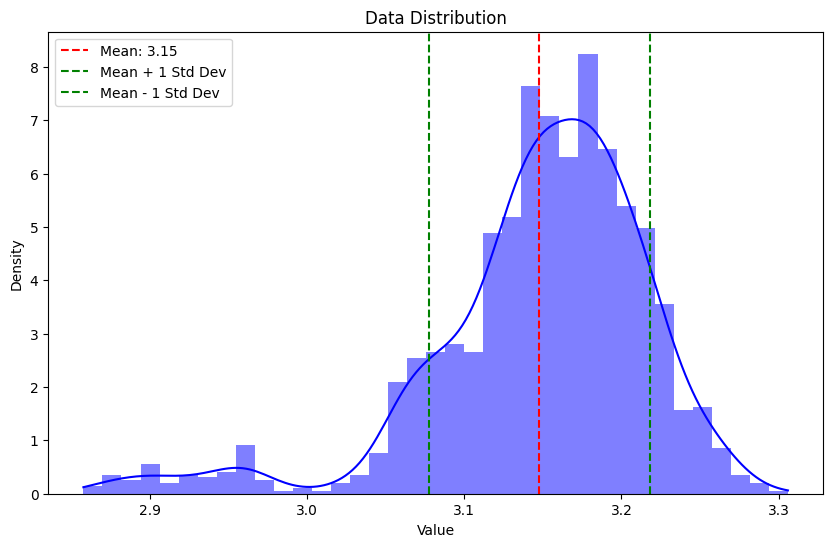

In [ ]:
mean=np.mean(spread)
std_dev=np.std(spread)
print(mean,std_dev)

import matplotlib.pyplot as plt
import seaborn as sns

# Example data
data = spread

# Create a histogram and a density plot
plt.figure(figsize=(10, 6))

# Plot histogram
sns.histplot(data, kde=True, color='blue', stat='density', linewidth=0)

# Plot the mean and standard deviation
plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
plt.axvline(mean + std_dev, color='green', linestyle='--', label=f'Mean + 1 Std Dev')
plt.axvline(mean - std_dev, color='green', linestyle='--', label=f'Mean - 1 Std Dev')

plt.title('Data Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

plt.show()


In [ ]:
import math
current_spread=math.log(4382)-hedge_ratio*math.log(1642)
print(current_spread)

z_score_of_current_spread=(current_spread-mean)/std_dev
print(z_score_of_current_spread)

3.138320486110951
-0.1333452808337074
